## Formatting a BSN Sports PDF <br/>

This is a walkthrough of the code behind formatting a BSN order. If you're boring and are not interested in how it works, basically all you need to do is first make sure your pdf's are in the *put_pdfs_here* folder and then click on the *formatting-bsn-orders.py* file. A *formatted.csv* will appear once the code has finished running. 

Also make sure your orders look something like this:
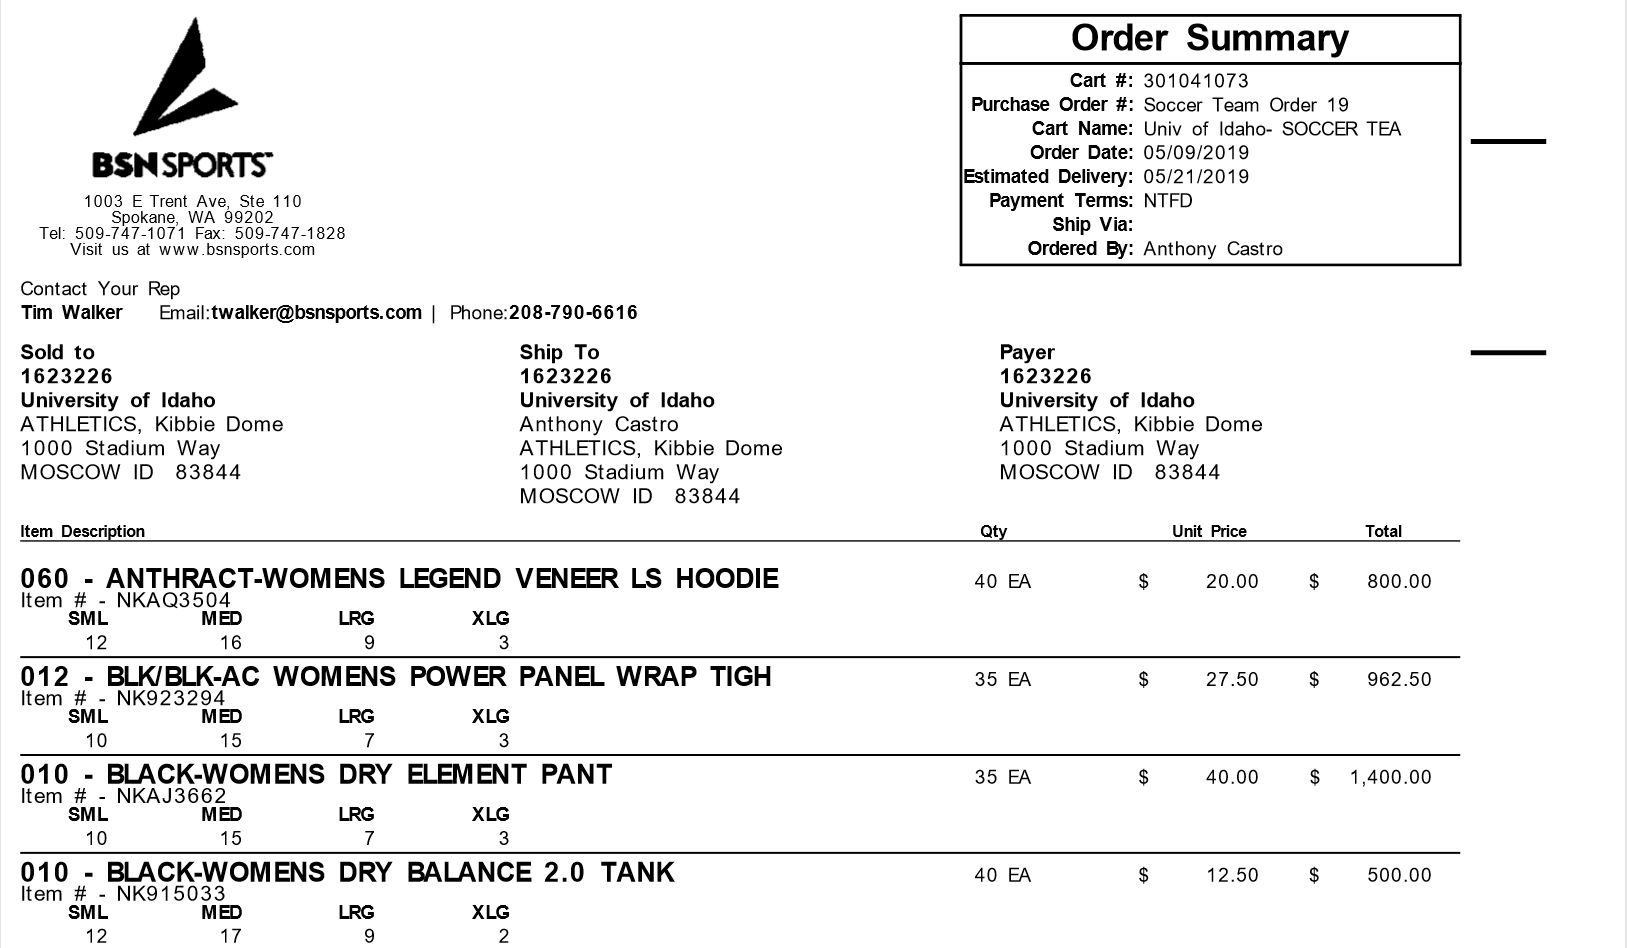

**Libraries used:**
- **pdfplumber**: opens pdfs and allows them to be parsed page by page
- **re**: finds patterns in text to know where to find specific data (e.g. dates, model numbers, etc.)
- **pandas**: used here for creating a data frame for exporting to a csv
- **glob**: allows for iterating through files ending in .pdf
<br/><br/>
**Note**: Make sure your pdfs are stored in the *put_pdfs_here* folder

In [1]:
import pdfplumber
import re
import pandas as pd
import glob

from collections import namedtuple 

In [2]:
# Creating a named tuple to easily make headings and assign values to a pandas data frame
Line = namedtuple('Line', 'sport_id order_date order_ref_number item_description item_category item_size qty_ordered chart item_unit item_pref_vendor item_manuf item_manuf_model item_price item_serial item_expendable item_universal')

**Regular Expressions**<br/>
The code below might look confusing at first but it is very useful to look for patterns in text. For example, manufacture models always start with "Item # - " and so we store that pattern in manuf_model_re for the extraction process later on.

You can learn more about regular expressions here: https://www.w3schools.com/python/python_regex.asp

In [3]:
manuf_model_re = re.compile(r'Item # - (.*)')
quantities_re = re.compile(r'\s*(\d*) ([A-Z]{2})\D*(\d*\.?\d*)')

**Extracting infoformation from the PDF** <br/>
This is where the actual extraction happens. We loop through each PDF file in the *put_pdfs_here* folder, each page in every file, and each line in every page. Each iteration checks for patterns that we previously defined and for other specific repetitions. Note that not every item has sizes associated, so we can't just loop through every item. We compile a list of all the lines that we need in the formatted file so that we can create a data fram out of it and export to a CSV.

In [4]:
lines = []
check_info = False
check_sizes = False

for file in glob.iglob("put_pdfs_here/*pdf"):
    with pdfplumber.open(file) as pdf:
        pages = pdf.pages
        for page in pdf.pages:
            text = page.extract_text()
            text_lines = text.split("\n")
            for i in range(len(text_lines)):
                
                # regular expressions - used for identifying patterns in text
                model_num = manuf_model_re.search(text_lines[i])
                
                # Order Date
                if text_lines[i].startswith('Order Date'):
                    order_date = re.compile(r'(\d{2}/\d{2}/\d{4})').search(text_lines[i]).group(1)
                
                # Order Reference Number
                elif text_lines[i].startswith('Cart Name'):
                    ref_num = re.compile(r'Cart Name:(.*)').search(text_lines[i]).group(1)
                
                # Manufacture Model
                elif model_num:
                    item_description = text_lines[i - 2]
                    manuf_model = model_num.group(1)
                    # check text_lines[i + 2] to see if there are sizes for current item
                    if bool(quantities_re.search(text_lines[i + 2])) or text_lines[i + 1].startswith('Subtotal'):
                        info = quantities_re.search(text_lines[i - 1])
                        qty = info.group(1)
                        item_unit = "Each" if info.group(2) == "EA" else "Pair"
                        price = info.group(3)
                        lines.append(Line("", order_date, ref_num, item_description, "", "", qty, "", item_unit, "", "BSN", manuf_model, price, "N", "Y", "N"))
                    else:
                        check_sizes = True
                    
                # Sizes
                elif check_sizes:
                    sizes = text_lines[i].split()
                    info = quantities_re.search(text_lines[i - 2])
                    qty = info.group(1)
                    item_unit = "Each" if info.group(2) == "EA" else "Pair"
                    price = info.group(3)
                    qtys = re.findall(r'\d+', text_lines[i + 1])
                    for i in range(len(qtys)):
                        lines.append(Line("", order_date, ref_num, item_description, "", sizes[i], qtys[i], "", item_unit, "", "BSN", manuf_model, price, "N", "Y", "N"))
                    check_sizes = False
                    
                              

**Creating the data frame** <br/>
Using the pandas library, we create a data frame out of the our lines array from above. Then we export the formatted file to a CSV and we're done! You should see a new *formatted.csv* pop up in the same directory as the python file.

In [5]:
df = pd.DataFrame(lines)

In [6]:
df.to_csv('formatted.csv', index=False)